In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
%matplotlib inline
#%matplotlib notebook
sns.set(rc={'figure.figsize':(11.7,8.27)})
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ks_2samp
import scipy.stats as stats
from scipy.stats import ttest_rel

In [2]:
data = pd.read_pickle('df_tesco_marker_V3.pkl')

In [95]:
data['medianADOVolSite'] = data.groupby('PBL')['volumeADO'].transform('median')
data['medianUL95VolSite'] = data.groupby('PBL')['volumeUL95'].transform('median')
data2 = data.query('volumeADO >=100')
data2['logVolAdo'] =   np.log(data2['volumeADO'])
data2['logP_by_P0_ADO'] = np.log(data2['ADO_ Approved Price']/data2['ADO_ Marker Price'])
data2['log_v_by_v0_ADO'] = np.log(data2.volumeADO/data2.medianADOVolSite)

data2['logVolUL95'] =   np.log(data2['volumeUL95'])
data2['logP_by_P0_UL95'] = np.log(data2['UL 95_ Approved Price']/data2['UL 95_ Marker Price'])
data2['log_v_by_v0_UL95'] = np.log(data2.volumeUL95/data2.medianUL95VolSite)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [96]:
#elasticity calculation :: forcing the intercept to zero 
def regRes_gen_const(site,x,y,prefix):
    cols = ['const','slope','rvalu','pvalue','count']
    cols_ref = list(map(lambda x: x+prefix,cols))
    try:
        # filter all data of the site between 5th & 95th precentile 
        #q_low,q_up = site[y].quantile([0.02,0.98]).values.round().tolist()
        #xf = site.loc[(site[y] >= q_low)& (site[y] <= q_up)]

        #q_low,q_up = site[x].quantile([0.02,0.98]).values.round().tolist()
        #xf = site.loc[(site[x] >= q_low)& (site[x] <= q_up)]

        x_train,y_train = site[x], site[y]
        x_train = sm.add_constant(x_train)

        model = sm.OLS(y_train,x_train).fit()
        const,slope,rvalu,pvalue = model.params[0],model.params[1],round(model.rsquared,2),model.pvalues[1]
        
        #slope,intercept,rvalu,pvalue,stderr= stats.linregress(xf[x],xf[y])

        return(pd.Series([const,slope,rvalu,pvalue,len(x_train)],index=cols_ref))
    except Exception as e:
        print(e)
        return(pd.Series([0,0,0,0,len(x_train)],index=cols_ref))

In [97]:
# fuel sales volume wrt ADO price position 
x_var = 'logP_by_P0_ADO'
ref = '_ADO'
data3 = data2.query('logP_by_P0_ADO != 0')[['Site Name','logVolAdo','logP_by_P0_ADO']].reset_index()
regFuelVolEl_ADO = data3.groupby('Site Name').apply(lambda site: \
                                                regRes_gen_const(site,x_var,'logVolAdo',ref)).reset_index()

In [98]:
# fuel sales volumne wrt UL
x_var = 'logP_by_P0_UL95'
ref = '_UL'
data3 = data2.query('logP_by_P0_UL95 != 0')[['Site Name','logVolUL95','logP_by_P0_UL95']].reset_index()
regFuelVolEl_UL = data3.groupby('Site Name').apply(lambda site: \
                                                regRes_gen_const(site,x_var,'logVolUL95',ref)).reset_index()

In [89]:
pdi_el_data = pd.read_excel(r'pdi_elaticity_values.xlsx')

pdi_el_data= pdi_el_data.pivot_table(index=['DisplayId','CatalistId'],columns='Grade',\
                                     values=['Elasticity']).reset_index()

pdi_el_data.columns = [' '.join(col).strip() for col in pdi_el_data.columns.values]

In [99]:
site_id_name = data.loc[:,['PBL', 'Site Name']].drop_duplicates()
regFuelVolEl_ADO_UL = regFuelVolEl_ADO.merge(regFuelVolEl_UL,how = 'left',on='Site Name')
regFuelVolEl_ADO_UL = regFuelVolEl_ADO_UL.merge(site_id_name,how = 'left',on='Site Name')

In [100]:
regFuelVolEl_ADO_UL_pdi = regFuelVolEl_ADO_UL.merge(pdi_el_data,how = 'left',left_on='PBL',right_on='DisplayId')

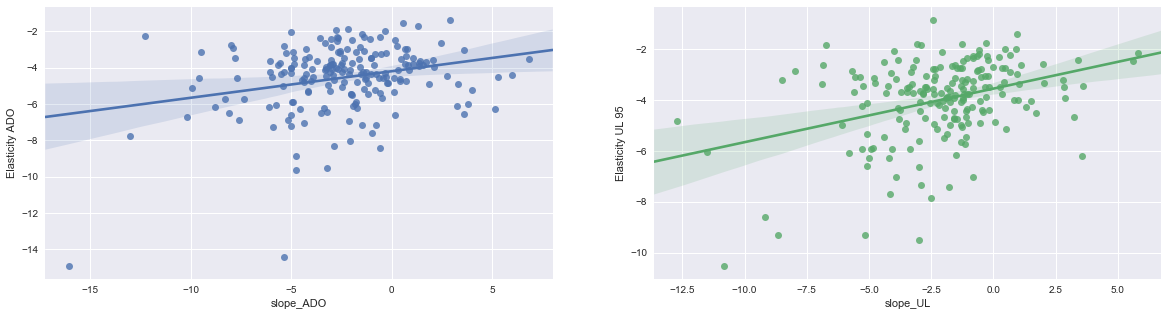

In [110]:
fig, ax = plt.subplots(1, 2,figsize=(20,5))
#fig.suptitle('Horizontally stacked subplots')
sns.regplot(x="slope_ADO", y="Elasticity ADO", data=regFuelVolEl_ADO_UL_pdi,ax=ax[0])
sns.regplot(x="slope_UL", y="Elasticity UL 95", data=regFuelVolEl_ADO_UL_pdi,ax=ax[1])

In [118]:
from scipy.stats import ks_2samp

In [119]:
test_stat = ks_2samp(regFuelVolEl_ADO_UL_pdi.slope_ADO.values, regFuelVolEl_ADO_UL_pdi["Elasticity ADO"].values)

In [120]:
test_stat

Ks_2sampResult(statistic=0.4744897959183674, pvalue=2.5059967451494054e-20)

In [122]:
slope,intercept,rvalu,pvalue,stderr= stats.linregress(regFuelVolEl_ADO_UL_pdi.slope_ADO\
                                                      ,regFuelVolEl_ADO_UL_pdi["Elasticity ADO"])

In [123]:
pvalue

0.00017965965448793657

In [124]:
def min_max_scaler (arr):
    return ( (arr-arr.min())/(arr.max()-arr.min()))

x_norm = min_max_scaler(regFuelVolEl_ADO_UL_pdi.slope_ADO)

y_norm = min_max_scaler(regFuelVolEl_ADO_UL_pdi["Elasticity ADO"])

In [129]:
ks_2samp(x_norm, y_norm)

Ks_2sampResult(statistic=0.576530612244898, pvalue=1.8720268824389878e-30)

In [130]:
ks_2samp(list(range(1,10)), list(range(1,10)))

Ks_2sampResult(statistic=0.0, pvalue=1.0)

In [144]:
q_labels = ['Very High','High','Medium','Low','Very Low']
regFuelVolEl_ADO_UL_pdi['pdi_ado_el_q'] = pd.qcut(regFuelVolEl_ADO_UL_pdi["Elasticity ADO"],q=5,labels=q_labels)

regFuelVolEl_ADO_UL_pdi['reg_ado_el_q'] = pd.qcut(regFuelVolEl_ADO_UL_pdi.slope_ADO,q=5,labels=q_labels)

In [151]:
pd.crosstab(regFuelVolEl_ADO_UL_pdi.reg_ado_el_q,regFuelVolEl_ADO_UL_pdi.pdi_ado_el_q,margins=True)

pdi_ado_el_q  Very High  High  Medium  Low  Very Low  All
reg_ado_el_q                                             
Very High            16     5       7    4         8   40
High                  8     7      10    9         5   39
Medium                7     7       7    8        10   39
Low                   4    14       8    6         7   39
Very Low              5     6       7   12         9   39
All                  40    39      39   39        39  196

In [153]:
stats.ttest_ind(regFuelVolEl_ADO_UL_pdi.slope_ADO.values, regFuelVolEl_ADO_UL_pdi["Elasticity ADO"].values,
                equal_var=False)

Ttest_indResult(statistic=7.8338548760301485, pvalue=8.013813926049915e-14)

In [154]:
stats.ttest_ind(x_norm, y_norm,equal_var=False)

Ttest_indResult(statistic=-11.896829488304407, pvalue=4.865656436576866e-28)